## CNN Demo Notebook

In this notebook we show how the CNN component in our project is trained and evaluated on smaller, anisotropic spatial data. 

This notebook is very similar in structure to the `i2i_demo.ipynb` notebook. 
For more details and guidance, please visit that notebook.

In [1]:
# imports required for CNN
import time
import torch
from torch.utils.data import DataLoader

from latticevision.device import set_device
from latticevision.plotting import plot_example_field, plot_losses

from latticevision.cnn.dataset import make_dataset, DataConfig
from latticevision.cnn.model import ModelConfig, CNN
from latticevision.cnn.train import TrainingConfig, train_model
from latticevision.cnn.eval import eval_model

# imports required for local CNN estimation on I2I data
from latticevision.img2img.dataset import make_dataset as make_img2img_dataset
from latticevision.img2img.dataset import DataConfig as Img2ImgDataConfig
from latticevision.cnn.eval import fast_cnn_field_tiler
from latticevision.plotting import plot_img2img_samples
from latticevision.img2img.eval import eval_model as eval_img2img_model
from latticevision.seed import set_all_random_seeds

In [2]:
# set random seed for reproducibility
set_all_random_seeds(777)

device = set_device(machine="remote", gpu=True, gpu_id="cuda:0", verbose=True)

Using device: cuda:0 
Hardware:  NVIDIA RTX A6000


In [3]:
dataset_path = "../data/CNN_sample_data.h5"
val_size = 0.4
test_size = 0.5

# dataset_path = "../data/CNN_data.h5"
# val_size = 0.1
# test_size = 0.2

data_config = DataConfig(
	file_path=dataset_path,
	fullsidelen=25,
	sidelen=25,
	n_replicates=30,
	n_params=3,
	log_kappa2=True,
	val_size=val_size,
	test_size=test_size,
	random_state=777,
	verbose=True,
)

data_dict = make_dataset(data_config)

train_df = data_dict["train_df"]
val_df = data_dict["val_df"]
test_df = data_dict["test_df"]

Components in the file: ['fields']
Dataset size (MB):  0.7392349243164062
Dataset size (GB):  0.0007219091057777405
Dims of 'fields': (5, 30, 25, 25)
Dims of 'params': (5, 3)
Train fields shape:  (3, 30, 25, 25)
Train params shape:  (3, 3)
Validation fields shape:  (1, 30, 25, 25)
Validation params shape:  (1, 3)
Test fields shape:  (1, 30, 25, 25)
Test params shape:  (1, 3)


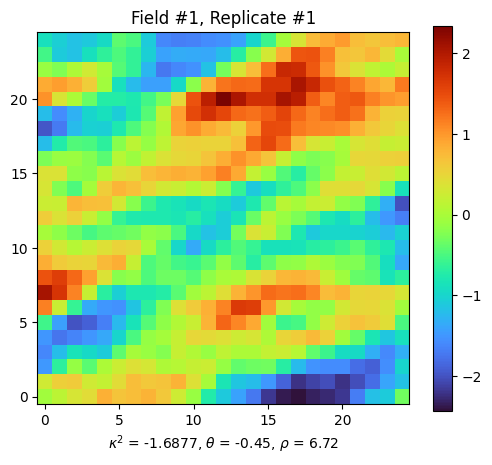

In [4]:
plot_example_field(
	dataset=train_df,
	config=data_config,
	idx=0,
	model_type="CNN",
	field_color="turbo",
)

In [5]:
# n_batch = 64
n_batch = 2

train_loader = DataLoader(train_df, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_df, batch_size=n_batch, shuffle=False)
test_loader = DataLoader(test_df, batch_size=n_batch, shuffle=False)

for fields, params in train_loader:
	print("Train Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

for fields, params in val_loader:
	print("Validation Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

for fields, params in test_loader:
	print("Test Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

Train Loader:
Fields batch shape:  torch.Size([2, 30, 25, 25]) 
Params batch shape:  torch.Size([2, 3])
Validation Loader:
Fields batch shape:  torch.Size([1, 30, 25, 25]) 
Params batch shape:  torch.Size([1, 3])
Test Loader:
Fields batch shape:  torch.Size([1, 30, 25, 25]) 
Params batch shape:  torch.Size([1, 3])


In [6]:
config = ModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

# config = ModelConfig(
#     sidelen=17,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (6,4,4),
#     padding = 0,
# )

# config = ModelConfig(
#     sidelen=9,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (2,2,2),
#     padding = 0,
# )

model = CNN(config).to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 2597815


In [7]:
start_time = time.time()

train_config = TrainingConfig(
	model=model,
	device=device,
	train_loader=train_loader,
	val_loader=val_loader,
	train_df=train_df,
	val_df=val_df,
	lr=1e-4,
	n_epochs=3,
	stop_patience=10,
	scheduler_patience=5,
	scheduler_factor=0.5,
	augmentation=False,
	save=False,  # switch to True to save model after training, currently this is just training for show
	save_directory="../results/model_wghts/",
	savename="cnn_wghts25_example.pth",
	verbose=True,
	normalize=True,
	shuffle=True,
)

training_results = train_model(config=train_config)

time_train = time.time() - start_time
print("Training took: ", time_train / 60, " minutes.")

model = training_results["model"]
train_losses = training_results["train_losses"]
val_losses = training_results["val_losses"]

Training for 3 epochs with learning rate 0.0001.
Model weights will not be saved.
Augmentation has been disabled.
Normalization has been enabled.
Shuffling has been enabled.
Epoch 1/3
Train Loss: 13.841002 - Val Loss: 11.259350
Learning Rate: 0.000100
Epoch 2/3
Train Loss: 13.799198 - Val Loss: 11.183412
Learning Rate: 0.000100
Epoch 3/3
Train Loss: 13.712198 - Val Loss: 11.079174
Learning Rate: 0.000100
Training complete. Best model weights loaded.
Training took:  0.007206090291341146  minutes.


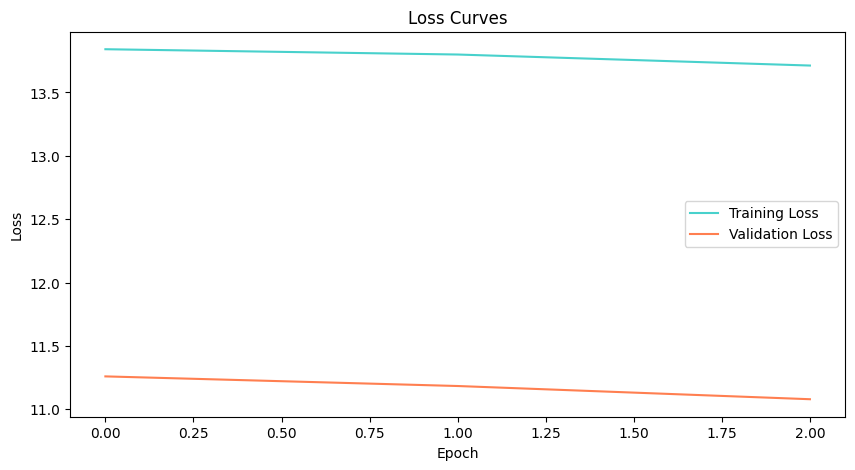

In [8]:
plot_losses(train_losses=train_losses, val_losses=val_losses)

In [9]:
config = ModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

# config = ModelConfig(
#     sidelen=17,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (6,4,4),
#     padding = 0,
# )

# config = ModelConfig(
#     sidelen=9,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (2,2,2),
#     padding = 0,
# )

model = CNN(config)
state_dict = torch.load(
	"../results/model_wghts/modelCNN_size25_reps30.pth", map_location=torch.device(device)
)
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(30, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): GELU(approximate='none')
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=2304, out_features=500, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=500, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

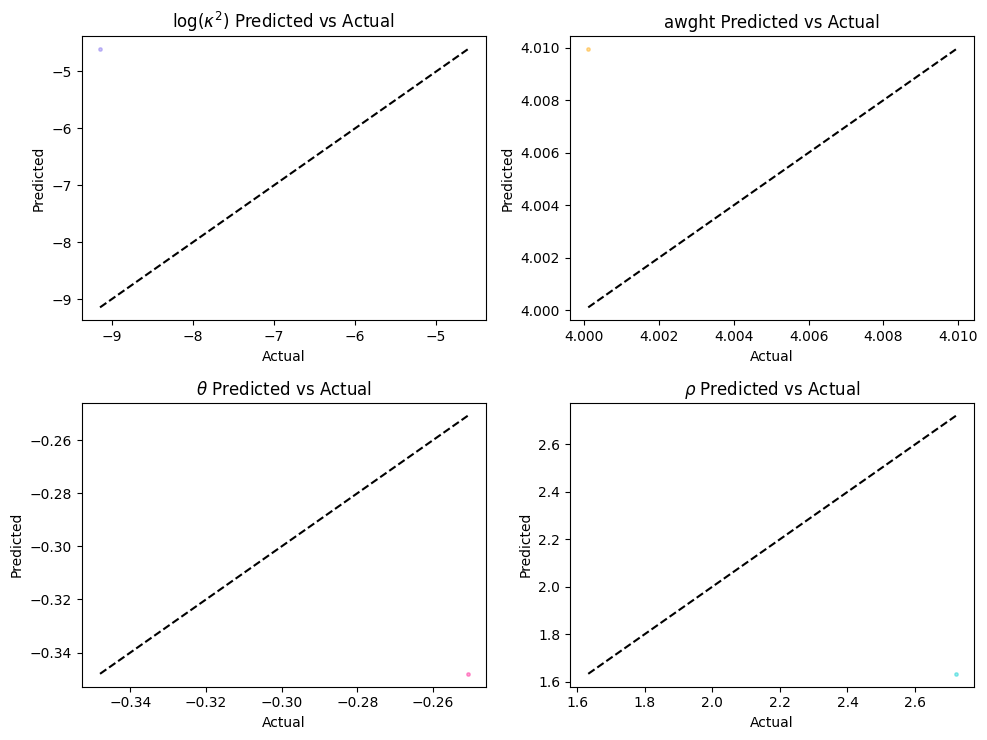

               rmse       mae            r2         nrmse
parameter                                                
kappa2     4.532923  4.532923 -2.054739e+07  4.532923e+06
theta      0.097098  0.097098 -9.427037e+03  9.709809e+04
rho        1.087635  1.087635 -1.182949e+06  1.087635e+06


In [10]:
metrics = eval_model(
	model=model,
	device=device,
	config=data_config,
	test_loader=test_loader,
	test_df=test_df,
	plot=True,
	augmentation=True,
)

### Local estimation on large image to image data 

We take a moving-window approach to local estimation, returning the same metrics and images as we do with our large vision models:


In [11]:
# for testing
dataset_path_i2i = "../data/I2I_sample_data.h5"
val_size_i2i = 0.4
test_size_i2i = 0.5

# dataset_path_i2i = "../data/STUN_data.h5"
# val_size_i2i = 0.1
# test_size_i2i = 0.2

data_config_i2i = Img2ImgDataConfig(
	file_path=dataset_path_i2i,
	n_rows=192,
	n_cols=288,
	n_replicates=30,
	n_params=3,
	log_kappa2=True,
	shift_theta=True,
	val_size=val_size_i2i,
	test_size=test_size_i2i,
	random_state=777,
	verbose=True,
)

data_dict = make_img2img_dataset(
	config=data_config_i2i,
)

test_df_i2i = data_dict["test_df"]

del data_dict

# n_batch = 64
n_batch = 2

# make loader and df are in same order for eval funcs
test_loader_i2i = DataLoader(test_df_i2i, batch_size=n_batch, shuffle=False)
for fields, params in test_loader_i2i:
	print("Test Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

Components in the file: ['fields']
Dataset size (MB):  69.60951232910156
Dataset size (GB):  0.06797803938388824
Fields shape:  (5, 30, 192, 288)
Params shape:  (5, 3, 192, 288)
Train fields shape:  (3, 30, 192, 288)
Train params shape:  (3, 3, 192, 288)
Validation fields shape:  (1, 30, 192, 288)
Validation params shape:  (1, 3, 192, 288)
Test fields shape:  (1, 30, 192, 288)
Test params shape:  (1, 3, 192, 288)
Test Loader:
Fields batch shape:  torch.Size([1, 30, 192, 288]) 
Params batch shape:  torch.Size([1, 3, 192, 288])


In [12]:
test_fields = test_df_i2i[:][0]
test_params = test_df_i2i[:][1]

print("Test fields shape: ", test_fields.shape)
print("Test params shape: ", test_params.shape)

outputs = torch.zeros(test_params.size())

Test fields shape:  torch.Size([1, 30, 192, 288])
Test params shape:  torch.Size([1, 3, 192, 288])


In [13]:
# fast option
for i in range(len(outputs)):
	output = fast_cnn_field_tiler(
		model=model,
		fields=test_fields[i].unsqueeze(0),
		device=device,
		patch_batch_size=10000,
		verbose=False,
		padding_mode="reflect",
		patch_size=25,
	)
	outputs[i] = output

# much slower option
# for i in range(len(outputs)):
#     output = slow_cnn_field_tiler(
#         model = model,
#         fields = test_fields[i].unsqueeze(0),
#         device = device,
#         padding_mode = "reflect",
#         verbose = True,
#         patch_size = 25,
#     )
#     outputs[i] = output

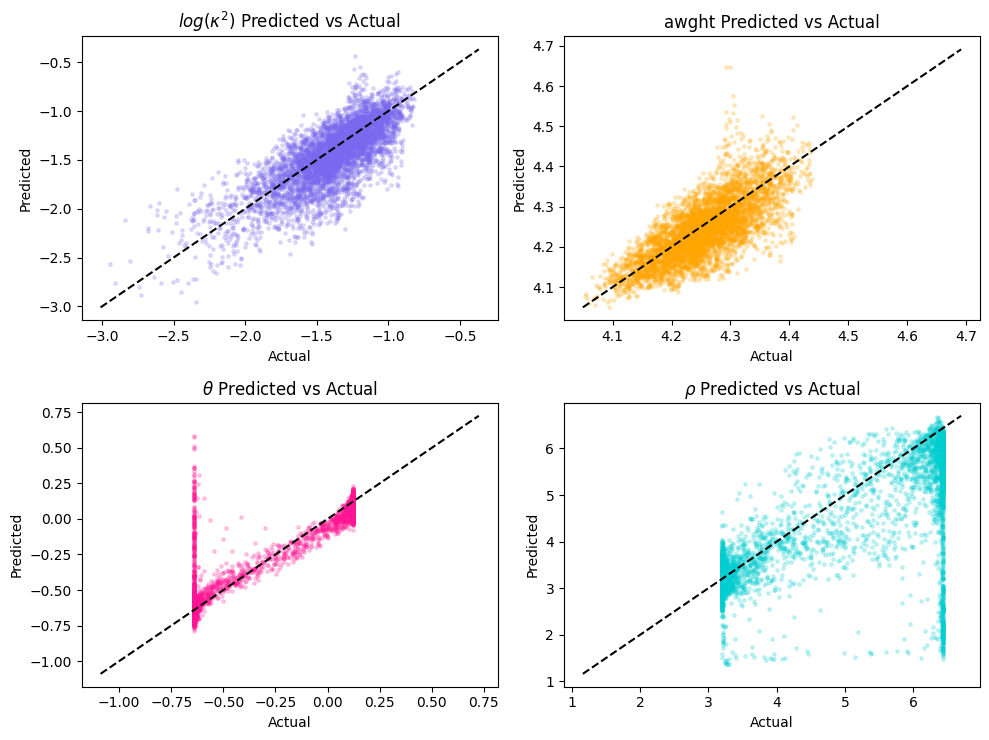

               rmse       mae        r2      ssim       psnr     nrmse
parameter                                                             
kappa2     0.232185  0.179695  0.400351  0.436360  19.330720  0.108010
theta      0.125841  0.059620  0.880706  0.536312  15.669292  0.164640
rho        1.133691  0.665394  0.383754  0.302529   9.091790  0.351083


In [14]:
metrics = eval_img2img_model(
	model=model,
	config=data_config_i2i,
	device=device,
	test_loader=test_loader_i2i,
	test_df=test_df_i2i,
	plot=True,
	augmentation=False,
	n_pixels=5000,
	show=True,
	cnn_mode=True,
	cnn_results=outputs,
)

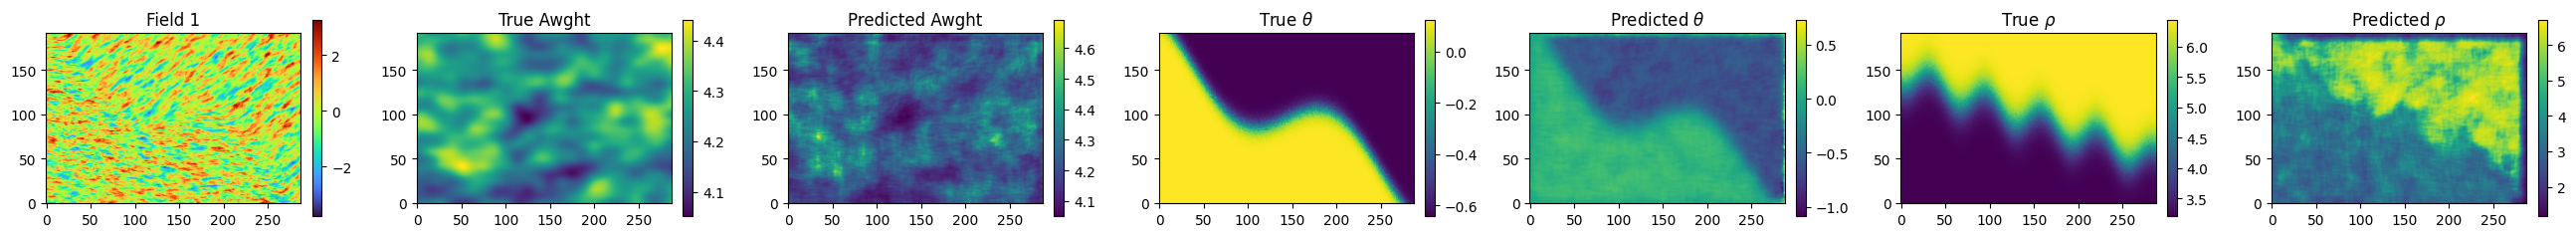

In [15]:
# inds = [0, 9, 16, 32, 37]
inds = [0] # for test dataset

plot_img2img_samples(
	model=model,
	config=data_config_i2i,
	device=device,
	test_df=test_df_i2i,
	indices=inds,
	random_selection=False,
	num_rand_samples=5,
	awght_not_kappa2=True,
	show=True,
	cnn_mode=True,
	cnn_results=outputs,
)